In [1]:
import warnings; 
warnings.filterwarnings("ignore")
warnings.simplefilter(action="ignore",category=UserWarning)
warnings.simplefilter(action="ignore",category=FutureWarning)


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from scipy import stats

import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from platform import python_version


print('Python version', python_version())
print('Numpy version', np.__version__)
print('Scipy version', sp.__version__)
print('Pandas version', pd.__version__)
print('Matplotlib version', mpl.__version__)
###############################################

#plt.style.use('ggplot')
plt.style.use('seaborn-v0_8-muted')
plt.rcParams['figure.figsize'] = (6, 6)
plt.rcParams['grid.linestyle'] = ':'   
plt.rcParams['axes.grid'] = False


%config InlineBackend.figure_formats = {'png', 'retina'}
%load_ext autoreload
%autoreload 2

Python version 3.13.1
Numpy version 2.2.2
Scipy version 1.15.1
Pandas version 2.2.3
Matplotlib version 3.10.0


# <font color='orange'> Random Forest </font>

## Load CHURN dataset

In [ ]:
import pandas as pd
churn_df = pd.read_excel('data/supervised-learning.xlsx', sheet_name='CHURN')
churn_df.head() 
churn_df.info()

,account_length,international_plan,voice_mail_plan,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,customer_service_calls,churn
0,128,no,yes,265.1,110,197.4,99,244.7,91,10.0,3,1,False
1,107,no,yes,161.6,123,195.5,103,254.4,103,13.7,3,1,False
2,137,no,no,243.4,114,121.2,110,162.6,104,12.2,5,0,False
3,84,yes,no,299.4,71,61.9,88,196.9,89,6.6,7,2,False
4,75,yes,no,166.7,113,148.3,122,186.9,121,10.1,3,3,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   account_length          3333 non-null   int64  
 1   international_plan      3333 non-null   object 
 2   voice_mail_plan         3333 non-null   object 
 3   total_day_minutes       3333 non-null   float64
 4   total_day_calls         3333 non-null   int64  
 5   total_eve_minutes       3333 non-null   float64
 6   total_eve_calls         3333 non-null   int64  
 7   total_night_minutes     3333 non-null   float64
 8   total_night_calls       3333 non-null   int64  
 9   total_intl_minutes      3333 non-null   float64
 10  total_intl_calls        3333 non-null   int64  
 11  customer_service_calls  3333 non-null   int64  
 12  churn                   3333 non-null   bool   
dtypes: bool(1), float64(4), int64(6), object(2)
memory usage: 315.9+ KB


: 

In [5]:
df = churn_df.copy()

## Proprocess data

Replace target labels

In [6]:
df['churn'] = np.where(df['churn'] == True, 'Churn', 'Not Churn')
df.churn.unique()
df.churn.value_counts()

array(['Not Churn', 'Churn'], dtype=object)

churn
Not Churn    2850
Churn         483
Name: count, dtype: int64

Variable encoding

In [7]:
from sklearn.preprocessing import OneHotEncoder

enc_onehot = OneHotEncoder(handle_unknown='ignore', 
                           drop='if_binary', dtype=int)
onehot_columns = ['international_plan', 'voice_mail_plan']
onehot_data = enc_onehot.fit_transform(df[onehot_columns])

onehot_df = pd.DataFrame(onehot_data.toarray(), 
                         columns=enc_onehot.get_feature_names_out(onehot_columns))

df = df.drop(onehot_columns, axis=1); 
df = pd.concat([df, onehot_df], axis=1)
df

,account_length,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,customer_service_calls,churn,international_plan_yes,voice_mail_plan_yes
0,128,265.1,110,197.4,99,244.7,91,10.0,3,1,Not Churn,0,1
1,107,161.6,123,195.5,103,254.4,103,13.7,3,1,Not Churn,0,1
2,137,243.4,114,121.2,110,162.6,104,12.2,5,0,Not Churn,0,0
3,84,299.4,71,61.9,88,196.9,89,6.6,7,2,Not Churn,1,0
4,75,166.7,113,148.3,122,186.9,121,10.1,3,3,Not Churn,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,192,156.2,77,215.5,126,279.1,83,9.9,6,2,Not Churn,0,1
3329,68,231.1,57,153.4,55,191.3,123,9.6,4,3,Not Churn,0,0
3330,28,180.8,109,288.8,58,191.9,91,14.1,6,2,Not Churn,0,0
3331,184,213.8,105,159.6,84,139.2,137,5.0,10,2,Not Churn,1,0


Separate feature set and target variable


In [8]:
X_train = df.drop('churn', axis=1)
y_train = df[['churn']]
X_train
y_train

,account_length,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,customer_service_calls,international_plan_yes,voice_mail_plan_yes
0,128,265.1,110,197.4,99,244.7,91,10.0,3,1,0,1
1,107,161.6,123,195.5,103,254.4,103,13.7,3,1,0,1
2,137,243.4,114,121.2,110,162.6,104,12.2,5,0,0,0
3,84,299.4,71,61.9,88,196.9,89,6.6,7,2,1,0
4,75,166.7,113,148.3,122,186.9,121,10.1,3,3,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3328,192,156.2,77,215.5,126,279.1,83,9.9,6,2,0,1
3329,68,231.1,57,153.4,55,191.3,123,9.6,4,3,0,0
3330,28,180.8,109,288.8,58,191.9,91,14.1,6,2,0,0
3331,184,213.8,105,159.6,84,139.2,137,5.0,10,2,1,0


,churn
0,Not Churn
1,Not Churn
2,Not Churn
3,Not Churn
4,Not Churn
...,...
3328,Not Churn
3329,Not Churn
3330,Not Churn
3331,Not Churn


## Fit Random forest model

In [9]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

In [10]:
rf_clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

## Evaluate train performance

In [11]:
# Evaluate the performance over the train data
from sklearn.metrics import classification_report

print(classification_report(y_train, rf_clf.predict(X_train)))

              precision    recall  f1-score   support

       Churn       1.00      1.00      1.00       483
   Not Churn       1.00      1.00      1.00      2850

    accuracy                           1.00      3333
   macro avg       1.00      1.00      1.00      3333
weighted avg       1.00      1.00      1.00      3333



In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

scoring_metrics = ['accuracy','precision_macro','recall_macro','f1_macro']
scores = cross_validate(RandomForestClassifier(), X_train,y_train, 
                        scoring=scoring_metrics, cv = 5, return_train_score= False)
scores_df = pd.DataFrame(scores)
scores_df

,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro
0,0.400444,0.023213,0.955022,0.951374,0.862471,0.899882
1,0.337864,0.018345,0.938531,0.921524,0.818602,0.859679
2,0.291362,0.017102,0.953523,0.950207,0.857316,0.896029
3,0.277869,0.015418,0.945946,0.949773,0.825493,0.873504
4,0.274010,0.017396,0.953453,0.955344,0.851535,0.893881


In [13]:
scores_df.mean()

fit_time                0.316310
score_time              0.018295
test_accuracy           0.949295
test_precision_macro    0.945644
test_recall_macro       0.843083
test_f1_macro           0.884595
dtype: float64

## Feature Importance

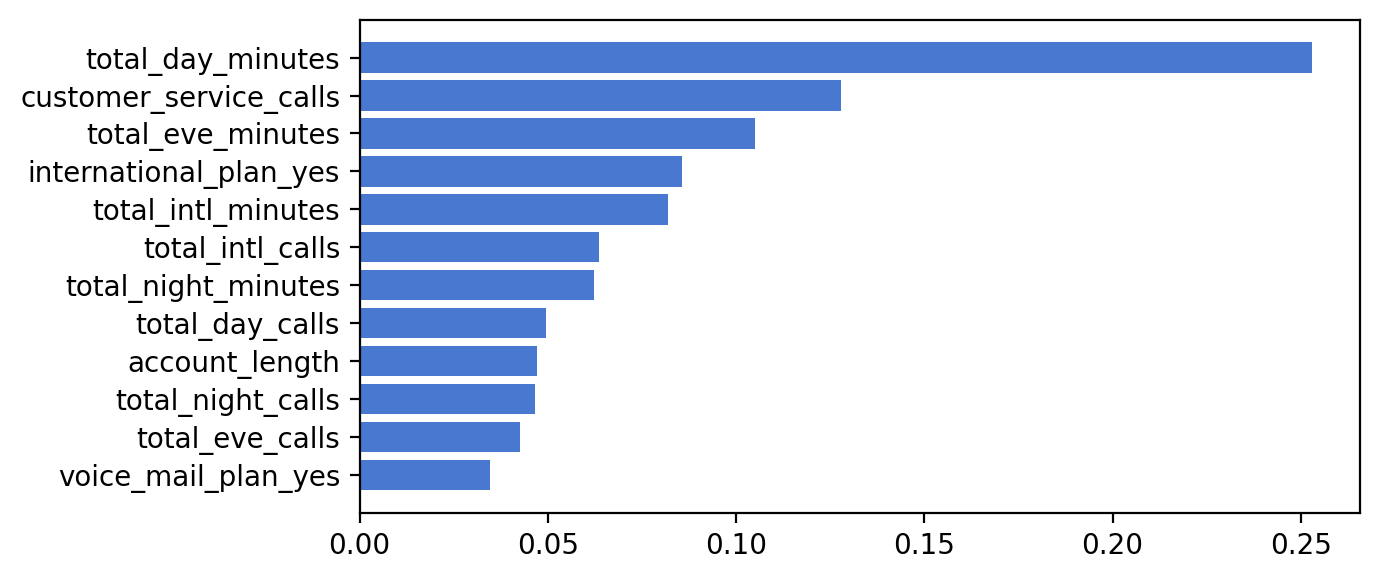

In [14]:
import matplotlib.pyplot as plt

feature_list = pd.DataFrame({'feature':X_train.columns, 'value':rf_clf.feature_importances_})
feature_list_sorted = feature_list.sort_values('value')
feature_list_sorted

plt.figure(figsize=(7,3))
plt.barh(range(0,len(feature_list_sorted.index)), 
         feature_list_sorted.value, tick_label=feature_list_sorted.feature)
plt.tight_layout();

# Hyperparameter Tuning
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [15]:
from sklearn.model_selection import GridSearchCV


# Parameters for tuning
K = 10
param_grid = [{'n_estimators':[20, 50, 100], 
               'max_depth': [5, 10, 15, None],
               'min_samples_leaf': [10, 20, 40]}]

print("Tuning hyper-parameters ...")
rf_gridsearch = GridSearchCV(RandomForestClassifier(), param_grid, cv = K, scoring = 'f1_macro')
rf_gridsearch.fit(X_train, y_train)

Tuning hyper-parameters ...


GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [5, 10, 15, None],
                          'min_samples_leaf': [10, 20, 40],
                          'n_estimators': [20, 50, 100]}],
             scoring='f1_macro')

#### Show the results

In [16]:
gridsearch_df = pd.DataFrame(rf_gridsearch.cv_results_) 
pd.set_option('display.max_colwidth', 100)
gridsearch_df[['params','mean_test_score']].sort_values('mean_test_score', ascending=False)[:10]

print(f"Best Estimator: \n{rf_gridsearch.best_estimator_}\n")
print(f"Best Parameters: \n{rf_gridsearch.best_params_}\n")
print(f"Best Test Score: \n{rf_gridsearch.best_score_}\n")

tuned_rf_clf = rf_gridsearch.best_estimator_ # Tuned model

,params,mean_test_score
19,"{'max_depth': 15, 'min_samples_leaf': 10, 'n_estimators': 50}",0.859297
20,"{'max_depth': 15, 'min_samples_leaf': 10, 'n_estimators': 100}",0.859231
11,"{'max_depth': 10, 'min_samples_leaf': 10, 'n_estimators': 100}",0.851216
28,"{'max_depth': None, 'min_samples_leaf': 10, 'n_estimators': 50}",0.846092
27,"{'max_depth': None, 'min_samples_leaf': 10, 'n_estimators': 20}",0.843407
29,"{'max_depth': None, 'min_samples_leaf': 10, 'n_estimators': 100}",0.842726
18,"{'max_depth': 15, 'min_samples_leaf': 10, 'n_estimators': 20}",0.839852
10,"{'max_depth': 10, 'min_samples_leaf': 10, 'n_estimators': 50}",0.838507
9,"{'max_depth': 10, 'min_samples_leaf': 10, 'n_estimators': 20}",0.833472
23,"{'max_depth': 15, 'min_samples_leaf': 20, 'n_estimators': 100}",0.781006


Best Estimator: 
RandomForestClassifier(max_depth=15, min_samples_leaf=10, n_estimators=50)

Best Parameters: 
{'max_depth': 15, 'min_samples_leaf': 10, 'n_estimators': 50}

Best Test Score: 
0.8592974054654727

